# FCCee Analysis Examples
Using the example `higgs/mH-recoil/mumu` from [FCCAnalyses](https://github.com/HEP-FCC/FCCAnalyses)

In [1]:
using EDM4hep
using EDM4hep.RootIO
using EDM4hep.SystemOfUnits
using EDM4hep.Histograms

## Definition of some analysis functions
These are couple of examples of high-level functions that makes use of `ReconstructedParticle` objects to build resonances and recoils. They make use of standard Julia functions to generate combinations, to sort a vector, and to work with LorentzVectors.  

In [2]:
# re-using convenient existing packages 
using LorentzVectorHEP
using Combinatorics

"""
    resonanceBuilder(rmass::AbstractFloat, legs::AbstractVector{ReconstructedParticle})

Returns a container with the best resonance of 2 by 2 combinatorics of the `legs` container
sorted by closest to the input `rmass` in absolute value.
"""
function resonanceBuilder(rmass::AbstractFloat, legs::AbstractVector{ReconstructedParticle})
    result = ReconstructedParticle[]
    length(legs) < 2 && return result
    for (a,b) in combinations(legs, 2)
        lv = LorentzVector(a.energy, a.momentum...) + LorentzVector(b.energy, b.momentum...)
        rcharge = a.charge + b.charge
        push!(result, ReconstructedParticle(mass=mass(lv), momentum=(lv.x, lv.y, lv.z), charge=rcharge))
    end
    sort!(result, lt =  (a,b) -> abs(rmass-a.mass) < abs(rmass-b.mass))
    return result[1:1]  # take the best one
end;

"""
    recoilBuilder(comenergy::AbstractFloat, legs::AbstractVector{ReconstructedParticle})

    build the recoil from an arbitrary list of input `ReconstructedParticle`s and the center of mass energy.
"""
function recoilBuilder(comenergy::AbstractFloat, in::AbstractVector{ReconstructedParticle})
    result = ReconstructedParticle[]
    isempty(in) && return result
    recoil_lv = LorentzVector(comenergy, 0, 0, 0)
    for p in in
        recoil_lv -= LorentzVector(p.mass, p.momentum...)
    end
    push!(result, ReconstructedParticle(mass=mass(recoil_lv), momentum=(recoil_lv.x, recoil_lv.y, recoil_lv.z)))
    return result
end;

## Defining the Histrograms
We create a custom structure with all the histograms intialized with their binning, units and titles. We use 
and the way of plotting them. We use the module `Parameters` that allows to create user structures with defaults.

In [3]:
using Parameters
using Plots

@with_kw struct Histograms
    mz          = H1D("m_{Z} [GeV]",125,0,250, unit=:GeV)
    mz_zoom     = H1D("m_{Z} [GeV]",40,80,100, unit=:GeV)
    lr_m        = H1D("Z leptonic recoil [GeV]", 100, 0, 200, unit=:GeV)
    lr_m_zoom   = H1D("Z leptonic recoil [GeV]", 200, 80, 160, unit=:GeV)
    lr_m_zoom1  = H1D("Z leptonic recoil [GeV]", 100, 120, 140, unit=:GeV)
    lr_m_zoom2  = H1D("Z leptonic recoil [GeV]", 200, 120, 140, unit=:GeV)
    lr_m_zoom3  = H1D("Z leptonic recoil [GeV]", 400, 120, 140, unit=:GeV)
    lr_m_zoom4  = H1D("Z leptonic recoil [GeV]", 800, 120, 140, unit=:GeV)
    lr_m_zoom5  = H1D("Z leptonic recoil [GeV]", 2000, 120, 140, unit=:GeV)
    lr_m_zoom6  = H1D("Z leptonic recoil [GeV]", 100, 130.3, 132.5, unit=:GeV)
end

function do_plot(histos::Histograms)
    img = plot(layout=(5,2), show=true, size=(1000,1500))
    for (i,fn) in enumerate(fieldnames(Histograms))
        h = getfield(histos, fn)
        plot!(subplot=i, h.hist, title=h.title, show=true, cgrad=:plasma)
    end
    return img
end

myhists = Histograms()

Histograms
  mz: H1D
  mz_zoom: H1D
  lr_m: H1D
  lr_m_zoom: H1D
  lr_m_zoom1: H1D
  lr_m_zoom2: H1D
  lr_m_zoom3: H1D
  lr_m_zoom4: H1D
  lr_m_zoom5: H1D
  lr_m_zoom6: H1D


## Open the data file to get the events
- It is using a file in EOS with the `root:` protocol
- The obtained `events` is a `LazyTree` created by the [UnROOT.jl](https://github.com/JuliaHEP/UnROOT.jl) package. As the name indicates no event is actually read yet.

In [4]:
f = "root://eospublic.cern.ch//eos/experiment/fcc/ee/generation/DelphesEvents/winter2023/IDEA/p8_ee_ZZ_ecm240/events_000189367.root"

reader = RootIO.Reader(f);
events = RootIO.get(reader, "events");

## Loop over events and fill the histograms

In [5]:
@time for evt in events
    #---get the collection of ReconstructedParticles and Muons
    recps = RootIO.get(reader, evt, "ReconstructedParticles");
    muons = RootIO.get(reader, evt, "Muon#0"; btype=ObjectID{ReconstructedParticle})
    
    sel_muons = filter(x -> pₜ(x) > 10GeV, muons)
    zed_leptonic = resonanceBuilder(91GeV, sel_muons)
    zed_leptonic_recoil = recoilBuilder(240GeV, zed_leptonic)
    if length(zed_leptonic) == 1    #  Filter to have exactly one Z candidate
        Zcand_m        = zed_leptonic[1].mass
        Zcand_recoil_m = zed_leptonic_recoil[1].mass
        Zcand_q        = zed_leptonic[1].charge
        if 80GeV <= Zcand_m <= 100GeV
            #---Fill histograms now--------------------------------------
            push!(myhists.mz, Zcand_m)
            push!(myhists.mz_zoom, Zcand_m)
            push!(myhists.lr_m, Zcand_recoil_m)
            push!(myhists.lr_m_zoom1, Zcand_recoil_m)
            push!(myhists.lr_m_zoom2, Zcand_recoil_m)
            push!(myhists.lr_m_zoom3, Zcand_recoil_m)
            push!(myhists.lr_m_zoom4, Zcand_recoil_m)
            push!(myhists.lr_m_zoom5, Zcand_recoil_m)
            push!(myhists.lr_m_zoom6, Zcand_recoil_m)
        end
    end
end

 28.356569 seconds (45.71 M allocations: 9.860 GiB, 6.40% gc time, 9.10% compilation time)


## Plot the results

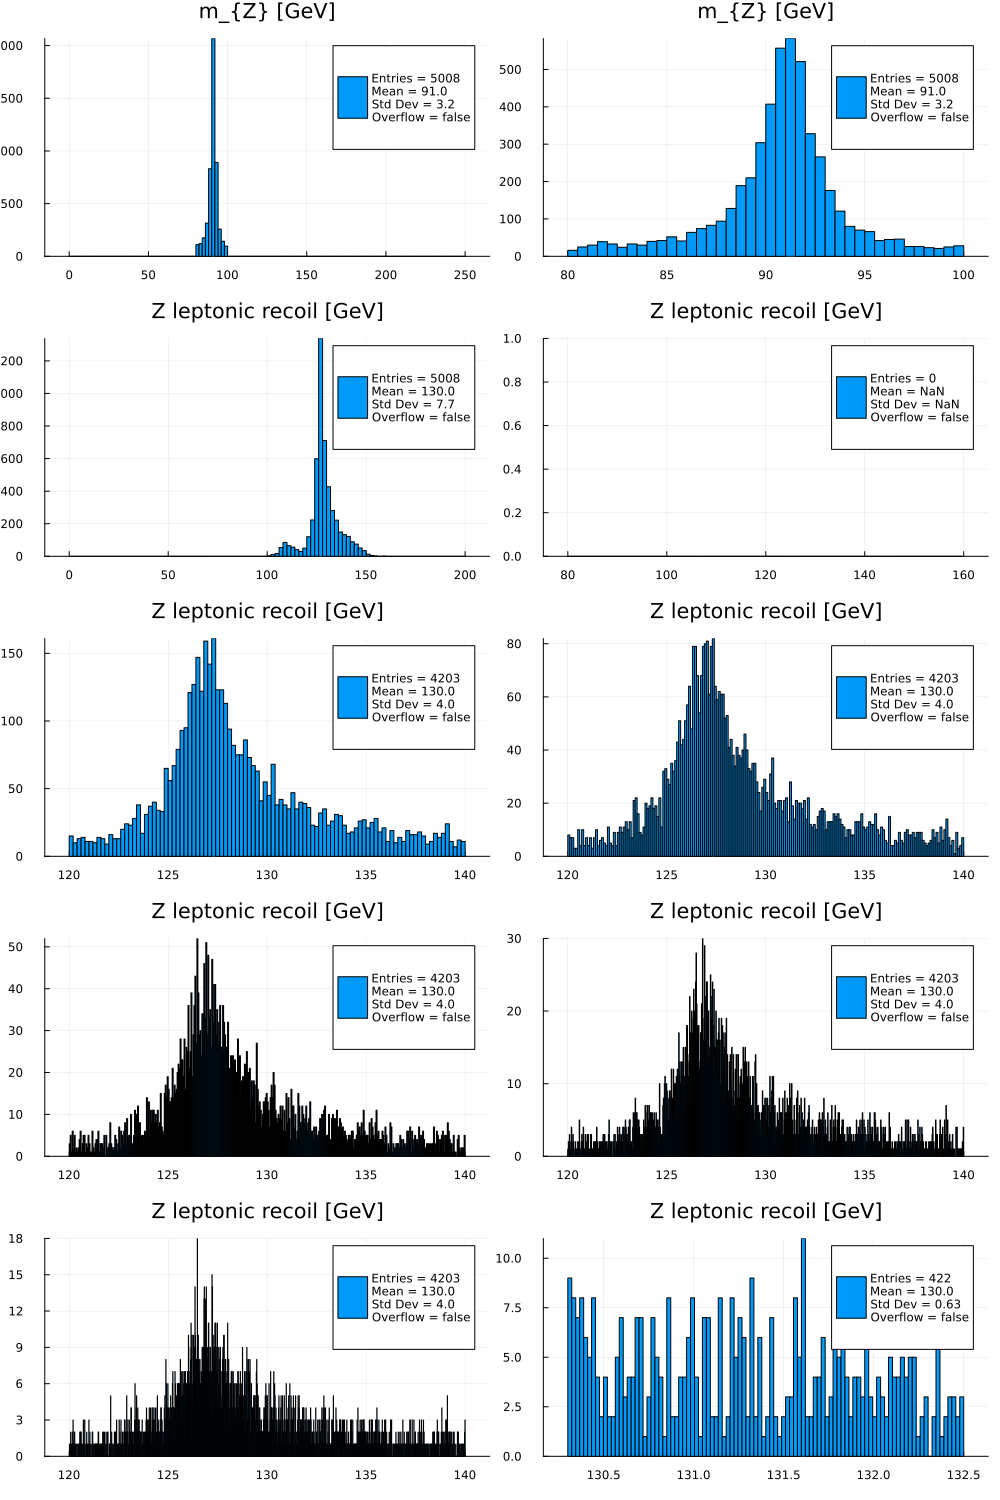

In [6]:
img = do_plot(myhists)
display("image/png", img)